<div>
      <img src="https://upload.wikimedia.org/wikipedia/de/5/5b/Hochschule-aalen.svg" width="400px" align="right"/>
</div>



## MLDL Projekt: 
# Implementierung von Deep Learning-Modellen 
##### Vergleich von keras (tensorflow) und pytorch
##### eigene Implementierung von Modellen
##### kritischer Vergleich, Schlussfolgerungen, etc.
## Vorhersage von Flugverspätungen in USA
---
Modul: Machine Learning & Deep Learning\
**Eugen Jeroschkin, Patrick Kurz, Andreas Schulz, Herbi Shtini**\
Submission: 14.10.2022 | SS2022 | Prof. Dr. Andreas Theissler

---

---
## Vorhersage von Flugverspätungen in USA
### Data Understanding & Data Preparation
---

<h2>Inhaltsverzeichnis</h1>
<ol>
  <li>Data-Visualization</li>
  <li>Outliers</li>
  <li>Data-Cleaning</li>
  <li>One-Hot-Encoding</li>
  <li>Dataset speichern</li>
</ol>

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt 

#import as_environ as ae # environment functions

In [2]:
if 'google.colab' in str(get_ipython()):
  IN_COLAB = True
else:
  IN_COLAB = False

if IN_COLAB:
  # Authenticate and create the PyDrive client.
  !pip install -U -q PyDrive
  from pydrive.auth import GoogleAuth
  from pydrive.drive import GoogleDrive
  from google.colab import auth
  from oauth2client.client import GoogleCredentials

  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)

  downloaded = drive.CreateFile({'id': '1aTfIHlWD53x0OaCo8wb3ae4NojbeVnwz'}) 
  downloaded.GetContentFile('2018.csv') 

In [3]:
df = pd.read_csv('2018.csv') 

In [ ]:
df.shape

(7213446, 28)

In [ ]:
df.columns

Index(['FL_DATE', 'OP_CARRIER', 'OP_CARRIER_FL_NUM', 'ORIGIN', 'DEST',
       'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'WHEELS_OFF',
       'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY',
       'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED', 'CRS_ELAPSED_TIME',
       'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'CARRIER_DELAY',
       'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY',
       'Unnamed: 27'],
      dtype='object')

In [4]:
pd.set_option('display.max_columns', None)
df.head(3)

,FL_DATE,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,CANCELLATION_CODE,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Unnamed: 27
0,2018-01-01,UA,2429,EWR,DEN,1517,1512.0,-5.0,15.0,1527.0,1712.0,10.0,1745,1722.0,-23.0,0.0,NaN,0.0,268.0,250.0,225.0,1605.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-01,UA,2427,LAS,SFO,1115,1107.0,-8.0,11.0,1118.0,1223.0,7.0,1254,1230.0,-24.0,0.0,NaN,0.0,99.0,83.0,65.0,414.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-01,UA,2426,SNA,DEN,1335,1330.0,-5.0,15.0,1345.0,1631.0,5.0,1649,1636.0,-13.0,0.0,NaN,0.0,134.0,126.0,106.0,846.0,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7213446 entries, 0 to 7213445
Data columns (total 28 columns):
 #   Column               Dtype  
---  ------               -----  
 0   FL_DATE              object 
 1   OP_CARRIER           object 
 2   OP_CARRIER_FL_NUM    int64  
 3   ORIGIN               object 
 4   DEST                 object 
 5   CRS_DEP_TIME         int64  
 6   DEP_TIME             float64
 7   DEP_DELAY            float64
 8   TAXI_OUT             float64
 9   WHEELS_OFF           float64
 10  WHEELS_ON            float64
 11  TAXI_IN              float64
 12  CRS_ARR_TIME         int64  
 13  ARR_TIME             float64
 14  ARR_DELAY            float64
 15  CANCELLED            float64
 16  CANCELLATION_CODE    object 
 17  DIVERTED             float64
 18  CRS_ELAPSED_TIME     float64
 19  ACTUAL_ELAPSED_TIME  float64
 20  AIR_TIME             float64
 21  DISTANCE             float64
 22  CARRIER_DELAY        float64
 23  WEATHER_DELAY        float64
 24

### Data-Visualization

In [ ]:
# 1. Cancelled per OP_CARRIER
dfCancelledShare = df.loc[df['CANCELLED'] > 0, ['OP_CARRIER', 'CANCELLED']].groupby('OP_CARRIER').sum()
dfCancelledShare['TOTAL'] = df[['OP_CARRIER', 'CANCELLED']].groupby('OP_CARRIER').count()
dfCancelledShare.reset_index(level=0, inplace=True)

# 2. Flights per OP_CARRIER
dsFlights = df.groupby('OP_CARRIER')['OP_CARRIER'].count().reset_index(name='Counts')

# 3. Flights number per Month
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
dateMonth = pd.to_datetime(df['FL_DATE']).dt.month_name()
dfFlightsMonth = dateMonth.value_counts().rename_axis('Month').reset_index(name='Flight counts')
dfFlightsMonth

# 4. Flights number per Day
dateDay = pd.to_datetime(df['FL_DATE']).dt.day_name()
dfFlightsDay = dateDay.value_counts().rename_axis('Day').reset_index(name='Flight counts')

# 5. Average delay per Month per carrier
dfDelay = df.loc[:, ['FL_DATE', 'ARR_DELAY']]
dfDelay['FL_DATE_MONTH'] = pd.to_datetime(dfDelay['FL_DATE']).dt.month_name()

delayCounts = dfDelay[['FL_DATE_MONTH', 'ARR_DELAY']].groupby('FL_DATE_MONTH').count()
delayValue = dfDelay[['FL_DATE_MONTH', 'ARR_DELAY']].groupby('FL_DATE_MONTH').sum()

dfMonthDelay = delayValue['ARR_DELAY'] / delayCounts['ARR_DELAY']
dfMonthDelay = dfMonthDelay.to_frame().reset_index().rename(columns={'ARR_DELAY': 'ARR_DELAY_AVG'})


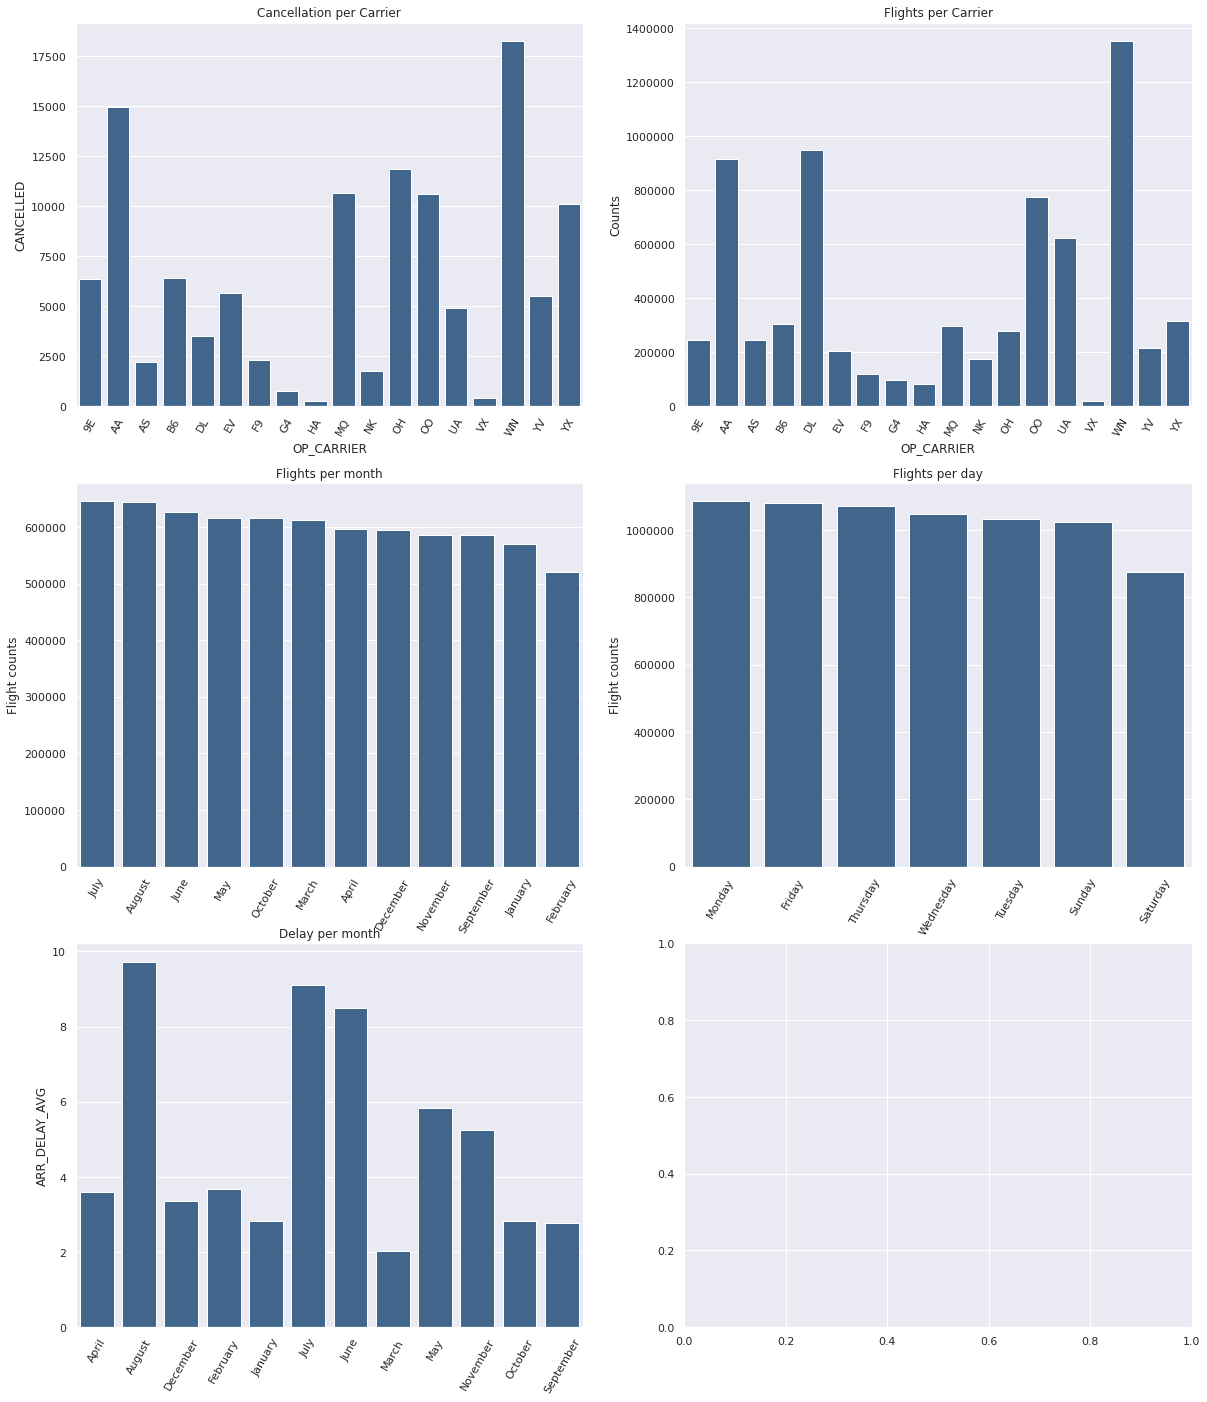

In [ ]:
sns.set_theme(style='darkgrid')
fig, ((ax1, ax2), (ax3, ax4) , (ax5, ax6)) = plt.subplots(3, 2, figsize=(20, 24))
# 1. Cancelled per OP_CARRIER
sns.barplot(data=dfCancelledShare, x='OP_CARRIER', y='CANCELLED', color=(0.2, 0.4, 0.6, 0.6), ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=60)
ax1.set(title='Cancellation per Carrier')
# 2. Flights per OP_CARRIER
sns.barplot(data=dsFlights, x='OP_CARRIER', y='Counts', color=(0.2, 0.4, 0.6, 0.6), ax=ax2)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=60)
ax2.set(title='Flights per Carrier')
# 3. Flights number per Month
sns.barplot(data=dfFlightsMonth, x='Month', y='Flight counts', color=(0.2, 0.4, 0.6, 0.6), ax=ax3)
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=60)
ax3.set(xlabel=None, title='Flights per month')
# 4. Flights number per Day
sns.barplot(data=dfFlightsDay, x='Day', y='Flight counts', color=(0.2, 0.4, 0.6, 0.6), ax=ax4)
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=60)
ax4.set(xlabel=None, title='Flights per day')
# 5. Average delay per Month per carrier
sns.barplot(data=dfMonthDelay, x='FL_DATE_MONTH', y='ARR_DELAY_AVG', color=(0.2, 0.4, 0.6, 0.6), ax=ax5)
ax5.set_xticklabels(ax5.get_xticklabels(), rotation=60)
ax5.set(xlabel=None, title='Delay per month')


ax2.yaxis.get_major_formatter().set_scientific(False)
ax3.yaxis.get_major_formatter().set_scientific(False)
ax4.yaxis.get_major_formatter().set_scientific(False)
ax5.yaxis.get_major_formatter().set_scientific(False)


#### Outliers

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


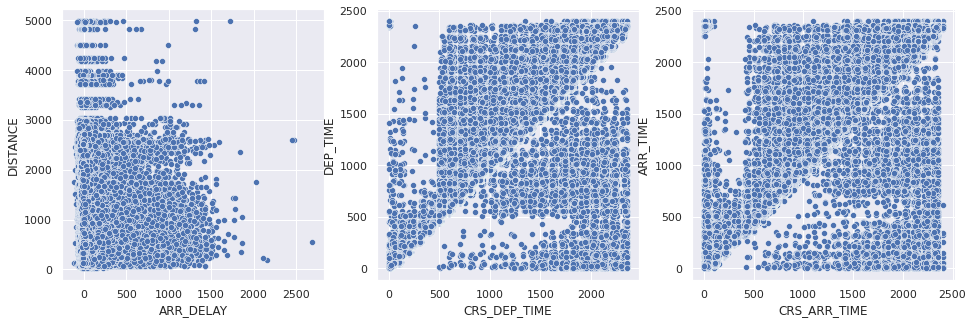

In [ ]:
fig, axs = plt.subplots(figsize=(16, 5), ncols=3)

sns.scatterplot(df['ARR_DELAY'], df['DISTANCE'], ax=axs[0])
sns.scatterplot(df['CRS_DEP_TIME'], df['DEP_TIME'], ax=axs[1])
sns.scatterplot(df['CRS_ARR_TIME'], df['ARR_TIME'], ax=axs[2])

In [ ]:
df.describe()

,OP_CARRIER_FL_NUM,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Unnamed: 27
count,7.213446e+06,7.213446e+06,7.101129e+06,7.096212e+06,7.097616e+06,7.097617e+06,7.094200e+06,7.094200e+06,7.213446e+06,7.094201e+06,7.076406e+06,7.213446e+06,7.213446e+06,7.213436e+06,7.079004e+06,7.079004e+06,7.213446e+06,1.352710e+06,1.352710e+06,1.352710e+06,1.352710e+06,1.352710e+06,0.0
mean,2.607531e+03,1.329687e+03,1.333854e+03,9.969858e+00,1.741061e+01,1.357799e+03,1.462162e+03,7.601246e+00,1.486341e+03,1.466784e+03,5.048581e+00,1.616204e-02,2.475793e-03,1.411356e+02,1.364999e+02,1.115020e+02,7.999895e+02,1.945501e+01,3.636459e+00,1.588547e+01,9.353890e-02,2.564412e+01,NaN
std,1.860122e+03,4.909320e+02,5.045055e+02,4.482964e+01,9.920409e+00,5.059721e+02,5.334675e+02,6.064797e+00,5.183124e+02,5.377089e+02,4.692664e+01,1.260985e-01,4.969571e-02,7.334433e+01,7.313758e+01,7.111293e+01,5.981783e+02,5.890812e+01,2.999601e+01,3.589350e+01,3.174306e+00,4.978776e+01,NaN
min,1.000000e+00,1.000000e+00,1.000000e+00,-1.220000e+02,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-1.200000e+02,0.000000e+00,0.000000e+00,-9.900000e+01,1.400000e+01,7.000000e+00,3.100000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN
25%,1.029000e+03,9.150000e+02,9.160000e+02,-5.000000e+00,1.100000e+01,9.320000e+02,1.044000e+03,4.000000e+00,1.100000e+03,1.049000e+03,-1.400000e+01,0.000000e+00,0.000000e+00,8.800000e+01,8.300000e+01,6.000000e+01,3.630000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN
50%,2.131000e+03,1.320000e+03,1.326000e+03,-2.000000e+00,1.500000e+01,1.340000e+03,1.502000e+03,6.000000e+00,1.515000e+03,1.506000e+03,-6.000000e+00,0.000000e+00,0.000000e+00,1.220000e+02,1.180000e+02,9.200000e+01,6.320000e+02,0.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00,3.000000e+00,NaN
75%,4.074000e+03,1.735000e+03,1.744000e+03,7.000000e+00,2.000000e+01,1.759000e+03,1.911000e+03,9.000000e+00,1.919000e+03,1.916000e+03,8.000000e+00,0.000000e+00,0.000000e+00,1.710000e+02,1.670000e+02,1.410000e+02,1.034000e+03,1.700000e+01,0.000000e+00,2.000000e+01,0.000000e+00,3.100000e+01,NaN
max,7.909000e+03,2.359000e+03,2.400000e+03,2.710000e+03,1.960000e+02,2.400000e+03,2.400000e+03,2.590000e+02,2.400000e+03,2.400000e+03,2.692000e+03,1.000000e+00,1.000000e+00,7.040000e+02,7.570000e+02,6.960000e+02,4.983000e+03,2.109000e+03,2.692000e+03,1.848000e+03,9.870000e+02,2.454000e+03,NaN


#### Data-Cleaning

Negative-Verspätung

In [5]:
df.loc[df['ARR_DELAY'] < 0, 'ARR_DELAY'] = 0

Outlier-Verspätung

In [6]:
df.loc[df['ARR_DELAY'] > 300, 'ARR_DELAY'] = 300

In [7]:
df[['ARR_DELAY']].describe()

,ARR_DELAY
count,7.076406e+06
mean,1.278740e+01
std,3.489308e+01
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,8.000000e+00
max,3.000000e+02


In [8]:
dfClean = df.copy()

dfClean.head(1)

,FL_DATE,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,CANCELLATION_CODE,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Unnamed: 27
0,2018-01-01,UA,2429,EWR,DEN,1517,1512.0,-5.0,15.0,1527.0,1712.0,10.0,1745,1722.0,0.0,0.0,NaN,0.0,268.0,250.0,225.0,1605.0,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
dfClean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7213446 entries, 0 to 7213445
Data columns (total 28 columns):
 #   Column               Dtype  
---  ------               -----  
 0   FL_DATE              object 
 1   OP_CARRIER           object 
 2   OP_CARRIER_FL_NUM    int64  
 3   ORIGIN               object 
 4   DEST                 object 
 5   CRS_DEP_TIME         int64  
 6   DEP_TIME             float64
 7   DEP_DELAY            float64
 8   TAXI_OUT             float64
 9   WHEELS_OFF           float64
 10  WHEELS_ON            float64
 11  TAXI_IN              float64
 12  CRS_ARR_TIME         int64  
 13  ARR_TIME             float64
 14  ARR_DELAY            float64
 15  CANCELLED            float64
 16  CANCELLATION_CODE    object 
 17  DIVERTED             float64
 18  CRS_ELAPSED_TIME     float64
 19  ACTUAL_ELAPSED_TIME  float64
 20  AIR_TIME             float64
 21  DISTANCE             float64
 22  CARRIER_DELAY        float64
 23  WEATHER_DELAY        float64
 24

In [10]:
# Adding new month column
dfClean['FL_DATE_MONTH'] = pd.to_datetime(dfClean['FL_DATE']).dt.month
# Adding new day of week column
dfClean['FL_DATE_WEEKDAY'] = pd.to_datetime(dfClean['FL_DATE']).dt.dayofweek + 1 # Turn it from 0-6 to 1-7

# Removing FL_DATE, OP_CARRIER, ORIGIN, DEST
dfClean.drop(columns=['FL_DATE', 'OP_CARRIER', 'ORIGIN', 'DEST', 'CANCELLATION_CODE'], inplace=True)
dfClean.head(1)

,OP_CARRIER_FL_NUM,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Unnamed: 27,FL_DATE_MONTH,FL_DATE_WEEKDAY
0,2429,1517,1512.0,-5.0,15.0,1527.0,1712.0,10.0,1745,1722.0,0.0,0.0,0.0,268.0,250.0,225.0,1605.0,NaN,NaN,NaN,NaN,NaN,NaN,1,1


In [11]:
class DataUtility:
    def __init__(self, df):
        self.df = df
        
    def getAvailableValues(self, norows = 5):   # input by the df and the number of rows that you want to show
        total = self.df.notnull().sum().sort_values(ascending=False)
        percent = ((self.df.notnull().sum().sort_values(ascending=False)/self.df.shape[0])*100).sort_values(ascending=False)
        missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

        return(missing_data.head(len(df.columns)))
    
    def getMinView(self, minVal):
        dfMin = self.getAvailableValues()
        dfMin = dfMin.loc[dfMin['Percent'] > minVal]

        return(dfMin)
    
    def getMaxView(self, maxVal):
        dfMax = self.getAvailableValues()
        dfMax = dfMax.loc[dfMax['Percent'] < maxVal]

        return(dfMax)
    
    def getMinDF(self, minVal):
        dfMin = dUtil.getMinView(minVal)
        self.df = self.df[dfMin.axes[0]]

        return(self.df)

In [12]:
dUtil = DataUtility(dfClean)
dfView = dUtil.getMaxView(100)
dfView

,Total,Percent
CRS_ELAPSED_TIME,7213436,99.999861
DEP_TIME,7101129,98.442949
WHEELS_OFF,7097617,98.394263
TAXI_OUT,7097616,98.394249
DEP_DELAY,7096212,98.374785
ARR_TIME,7094201,98.346907
WHEELS_ON,7094200,98.346893
TAXI_IN,7094200,98.346893
ACTUAL_ELAPSED_TIME,7079004,98.136231
AIR_TIME,7079004,98.136231


#### Removing NULL values

In [13]:
# Cancelled & Delays
for item in ['CANCELLED', 'ARR_DELAY', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']:
  dfClean[item] = dfClean[item].fillna(0)

In [14]:
dUtil = DataUtility(dfClean)
dfView = dUtil.getMaxView(100)
dfView

,Total,Percent
CRS_ELAPSED_TIME,7213436,99.999861
DEP_TIME,7101129,98.442949
WHEELS_OFF,7097617,98.394263
TAXI_OUT,7097616,98.394249
DEP_DELAY,7096212,98.374785
ARR_TIME,7094201,98.346907
TAXI_IN,7094200,98.346893
WHEELS_ON,7094200,98.346893
ACTUAL_ELAPSED_TIME,7079004,98.136231
AIR_TIME,7079004,98.136231


In [15]:
dfClean['ARR_TIME'].unique()

array([1722., 1230., 1636., ...,  326.,  329.,  347.])

### Times

Die Zeite sollten immer verfügbar sein, da wir können sie selbst nicht korrekt ausfüllen. Um es zu ermöglichen müssen wir uns Diejenigen die nicht verfügbar sind ausfiltern.

In [16]:
# Remove not available times
dfClean = dfClean.loc[ ~df['DEP_TIME'].isna()  
                      & ~df['ARR_TIME'].isna()
                      & ~df['DEP_DELAY'].isna()
                      & ~df['WHEELS_OFF'].isna()
                      & ~df['WHEELS_ON'].isna()
                      & ~df['TAXI_IN'].isna()
                      & ~df['TAXI_OUT'].isna()
                      & ~df['ACTUAL_ELAPSED_TIME'].isna()
                      & ~df['AIR_TIME'].isna()
                     ]

In [17]:
#Clean data and remove not required items
#reason:
#    'Unnamed: 27': No values
#    'Unnamed: 0': ID Column from original csv
#    'OP_CARRIER_FL_NUM': Not possible to identify
#                         Carrier with it
dfClean = dfClean.drop(['Unnamed: 27', 'OP_CARRIER_FL_NUM'], axis = 1)

In [18]:
#Transform datatypes to reduce storage size
#dfClean = ae.squeeze_dataframe(dfClean)

In [19]:
dUtil = DataUtility(dfClean)
dfView = dUtil.getMaxView(0)
dfView

,Total,Percent


Wir filtern 800 Tausend random Zeilen heraus.

In [20]:
dfCleanSample = dfClean.sample(n = 800000, ignore_index=True)
dfCleanSampleFiltered = dfCleanSample[['FL_DATE_MONTH', 'FL_DATE_WEEKDAY', 'CRS_DEP_TIME', 'DISTANCE', 'CRS_ELAPSED_TIME', 'ARR_DELAY']]

In [ ]:
dfCleanSampleFiltered.head(5)

,FL_DATE_MONTH,FL_DATE_WEEKDAY,CRS_DEP_TIME,DISTANCE,CRS_ELAPSED_TIME,ARR_DELAY
0,9,6,946,420.0,96.0,0.0
1,5,2,1320,333.0,86.0,5.0
2,11,4,940,1771.0,225.0,0.0
3,3,3,545,172.0,67.0,0.0
4,10,2,1941,2248.0,362.0,0.0


#### Dataset speichern (ohne One Hot Encoding)

In [21]:
dfCleanSample.to_csv('2018-prepared-sampleKeras.csv', index=False)
dfCleanSampleFiltered.to_csv('2018-prepared-filtered-sampleKeras.csv', index=False)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#### One-Hot-Encoding

In [ ]:
# Weekday
one_hot_weekday = pd.get_dummies(dfCleanSampleFiltered['FL_DATE_WEEKDAY'], prefix='FL_DATE_WEEKDAY')
dfCleanSampleFiltered = dfCleanSampleFiltered.drop('FL_DATE_WEEKDAY', axis = 1)
dfCleanSampleFiltered = dfCleanSampleFiltered.join(one_hot_weekday)

# MONTH
one_hot_month = pd.get_dummies(dfCleanSampleFiltered['FL_DATE_MONTH'], prefix='FL_DATE_MONTH')
dfCleanSampleFiltered = dfCleanSampleFiltered.drop('FL_DATE_MONTH', axis = 1)
dfCleanSampleFiltered = dfCleanSampleFiltered.join(one_hot_month)

dfCleanSampleFiltered.head(3)

,CRS_DEP_TIME,DISTANCE,CRS_ELAPSED_TIME,ARR_DELAY,FL_DATE_WEEKDAY_1,FL_DATE_WEEKDAY_2,FL_DATE_WEEKDAY_3,FL_DATE_WEEKDAY_4,FL_DATE_WEEKDAY_5,FL_DATE_WEEKDAY_6,FL_DATE_WEEKDAY_7,FL_DATE_MONTH_1,FL_DATE_MONTH_2,FL_DATE_MONTH_3,FL_DATE_MONTH_4,FL_DATE_MONTH_5,FL_DATE_MONTH_6,FL_DATE_MONTH_7,FL_DATE_MONTH_8,FL_DATE_MONTH_9,FL_DATE_MONTH_10,FL_DATE_MONTH_11,FL_DATE_MONTH_12
0,946,420.0,96.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
1,1320,333.0,86.0,5.0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,940,1771.0,225.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


### Dataset speichern

In [ ]:
dfCleanSample.to_csv('2018-prepared-sample.csv', index=False)
dfCleanSampleFiltered.to_csv('2018-prepared-filtered-sample.csv', index=False)